In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)
    
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)


sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 1.26.4
pandas 2.2.3
sklearn 1.6.0
torch 2.5.1+cpu
cpu


## 准备数据

In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(data_home='data')
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [3]:
# print(housing.data[0:5])
import pprint  #打印的格式比较 好看

pprint.pprint(housing.data[0:2])
print('-'*50)
pprint.pprint(housing.target[0:2])

array([[ 8.32520000e+00,  4.10000000e+01,  6.98412698e+00,
         1.02380952e+00,  3.22000000e+02,  2.55555556e+00,
         3.78800000e+01, -1.22230000e+02],
       [ 8.30140000e+00,  2.10000000e+01,  6.23813708e+00,
         9.71880492e-01,  2.40100000e+03,  2.10984183e+00,
         3.78600000e+01, -1.22220000e+02]])
--------------------------------------------------
array([4.526, 3.585])


In [3]:
from sklearn.model_selection import train_test_split

#拆分训练集和测试集，random_state是随机种子,同样的随机数种子，是为了得到同样的随机值
x_train_all, x_test, y_train_all, y_test = train_test_split(
    housing.data, housing.target, random_state = 7)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state = 11)
# 训练集
print(x_train.shape, y_train.shape)
# 验证集
print(x_valid.shape, y_valid.shape)
# 测试集
print(x_test.shape, y_test.shape)

dataset_maps = {
    "train": [x_train, y_train], #训练集
    "valid": [x_valid, y_valid], #验证集
    "test": [x_test, y_test], #测试集
} #把3个数据集都放到字典中


(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [5]:
type(x_train)

numpy.ndarray

In [4]:
from sklearn.preprocessing import StandardScaler



scaler = StandardScaler() #标准化
scaler.fit(x_train) #fit和fit_transform的区别，fit是计算均值和方差，fit_transform是先fit，然后transform

StandardScaler()

In [7]:
np.array(1).shape

()

### 构建数据集

In [7]:
#构建私有数据集，就需要用如下方式
from torch.utils.data import Dataset
# from torch.utils import data

class HousingDataset(Dataset):
    def __init__(self, mode='train'):
        self.x, self.y = dataset_maps[mode] #x,y都是ndarray类型
        self.x = torch.from_numpy(scaler.transform(self.x)).float() #from_numpy将NumPy数组转换成PyTorch张量
        self.y = torch.from_numpy(self.y).float().reshape(-1, 1) #处理为多行1列的tensor类型,因为__getitem__切片时需要
            
    def __len__(self): #必须写
        return len(self.x) #返回数据集的长度,0维的size
    
    def __getitem__(self, idx): #idx是索引，返回的是数据和标签，这里是一个样本
        return self.x[idx], self.y[idx]
    
#train_ds是dataset类型的数据，与前面例子的FashionMNIST类型一致
train_ds = HousingDataset("train")
valid_ds = HousingDataset("valid")
test_ds = HousingDataset("test")

In [9]:
type(train_ds)

__main__.HousingDataset

In [6]:
len(train_ds)

11610

In [9]:
train_ds[:2]

(tensor([[ 0.8015,  0.2722, -0.1162, -0.2023, -0.5431, -0.0210, -0.5898, -0.0824],
         [-0.2981,  0.3523, -0.1092, -0.2506, -0.0341, -0.0060,  1.0806, -1.0611]]),
 tensor([[3.2260],
         [1.5140]]))

In [11]:
train_ds[0][0]

tensor([ 0.8015,  0.2722, -0.1162, -0.2023, -0.5431, -0.0210, -0.5898, -0.0824])

### DataLoader

In [10]:
from torch.utils.data import DataLoader

#放到DataLoader中的train_ds, valid_ds, test_ds都是dataset类型的数据
batch_size = 16 #batch_size是可以调的超参数
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

## 定义模型

In [11]:
#回归模型我们只需要1个数

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim=8):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 30),
            nn.ReLU(),
            nn.Linear(30, 1)
            )
        
    def forward(self, x):
        # x.shape [batch size, 8]
        logits = self.linear_relu_stack(x)
        # logits.shape [batch size, 1]
        return logits

In [12]:
8*30+30+30*1+1

301

In [13]:
#帮我计算模型总参数量
total_params = sum(p.numel() for p in NeuralNetwork().parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 301


In [14]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute 
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0
        
    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter 
            self.counter = 0
        else: 
            self.counter += 1
            
    @property
    def early_stop(self):
        return self.counter >= self.patience


In [15]:
from sklearn.metrics import accuracy_score

@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    for datas, labels in dataloader:
        datas = datas.to(device)
        labels = labels.to(device)
        # 前向计算
        logits = model(datas)
        loss = loss_fct(logits, labels)         # 验证集损失
        loss_list.append(loss.item())
        
    return np.mean(loss_list)


In [16]:
# 训练
def training(
    model, 
    train_loader, 
    val_loader, 
    epoch, 
    loss_fct, 
    optimizer,
    early_stop_callback=None,
    eval_step=500,
    ):
    record_dict = {
        "train": [],
        "val": []
    }
    
    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:#11610/16=726
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas) #得到预测值
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
 
                loss = loss.cpu().item() #转为cpu类型，item()是取值
                # record
                
                record_dict["train"].append({
                    "loss": loss, "step": global_step
                })
                
                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "step": global_step
                    })
                    model.train()

                    # 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(-val_loss) #根据验证集的损失来实现早停
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict
                    
                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})
        
    return record_dict
        

epoch = 100

model = NeuralNetwork()

# 1. 定义损失函数 采用MSE损失,均方误差
loss_fct = nn.MSELoss()
# 2. 定义优化器 采用SGD
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 3. early stop
early_stop_callback = EarlyStopCallback(patience=10, min_delta=1e-3)

model = model.to(device)
record = training(
    model, 
    train_loader, 
    val_loader, 
    epoch, 
    loss_fct, 
    optimizer, 
    early_stop_callback=early_stop_callback,
    eval_step=len(train_loader)
    )

  0%|          | 0/72600 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=2000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=2000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=2000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

Early stop at epoch 53 / global_step 38478


In [20]:
record["train"][-5:]

[{'loss': 0.4463195502758026, 'step': 38474},
 {'loss': 0.32607290148735046, 'step': 38475},
 {'loss': 0.540153443813324, 'step': 38476},
 {'loss': 0.13538116216659546, 'step': 38477},
 {'loss': 0.08177245408296585, 'step': 38478}]

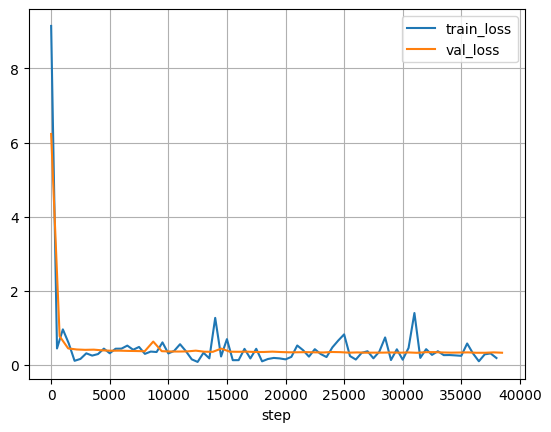

In [21]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=500):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")

    # plot
    for idx, item in enumerate(train_df.columns):
        plt.plot(train_df.index, train_df[item], label=f"train_{item}")
        plt.plot(val_df.index, val_df[item], label=f"val_{item}")
        plt.grid()
        plt.legend()
        # plt.xticks(range(0, train_df.index[-1], 10*sample_step), range(0, train_df.index[-1], 10*sample_step))
        plt.xlabel("step")

        plt.show()

plot_learning_curves(record)  #横坐标是 steps

## 测试集

In [22]:
model.eval()
loss = evaluating(model, test_loader, loss_fct)
print(f"loss:     {loss:.4f}")

loss:     0.3307
